2025-11-01 18:53:56,062 | INFO | Data loaded and selectively merged (Price only).
/Users/riyabharathwaj/Documents/Riya MSA/CS7641-ML/ML Project/OOS-Product-Recommendation-Engine/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/riyabharathwaj/Documents/Riya MSA/CS7641-ML/ML Project/OOS-Product-Recommendation-Engine/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/riyabharathwaj/Documents/Riya MSA/CS7641-ML/ML Project/OOS-Product-Recommendation-Engine/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/riyabharathwaj/Documents/Riya MSA/CS7641-ML/ML Project/OOS-Product-Recommendation-Engine/.venv/lib/python3.13/site-packages/n

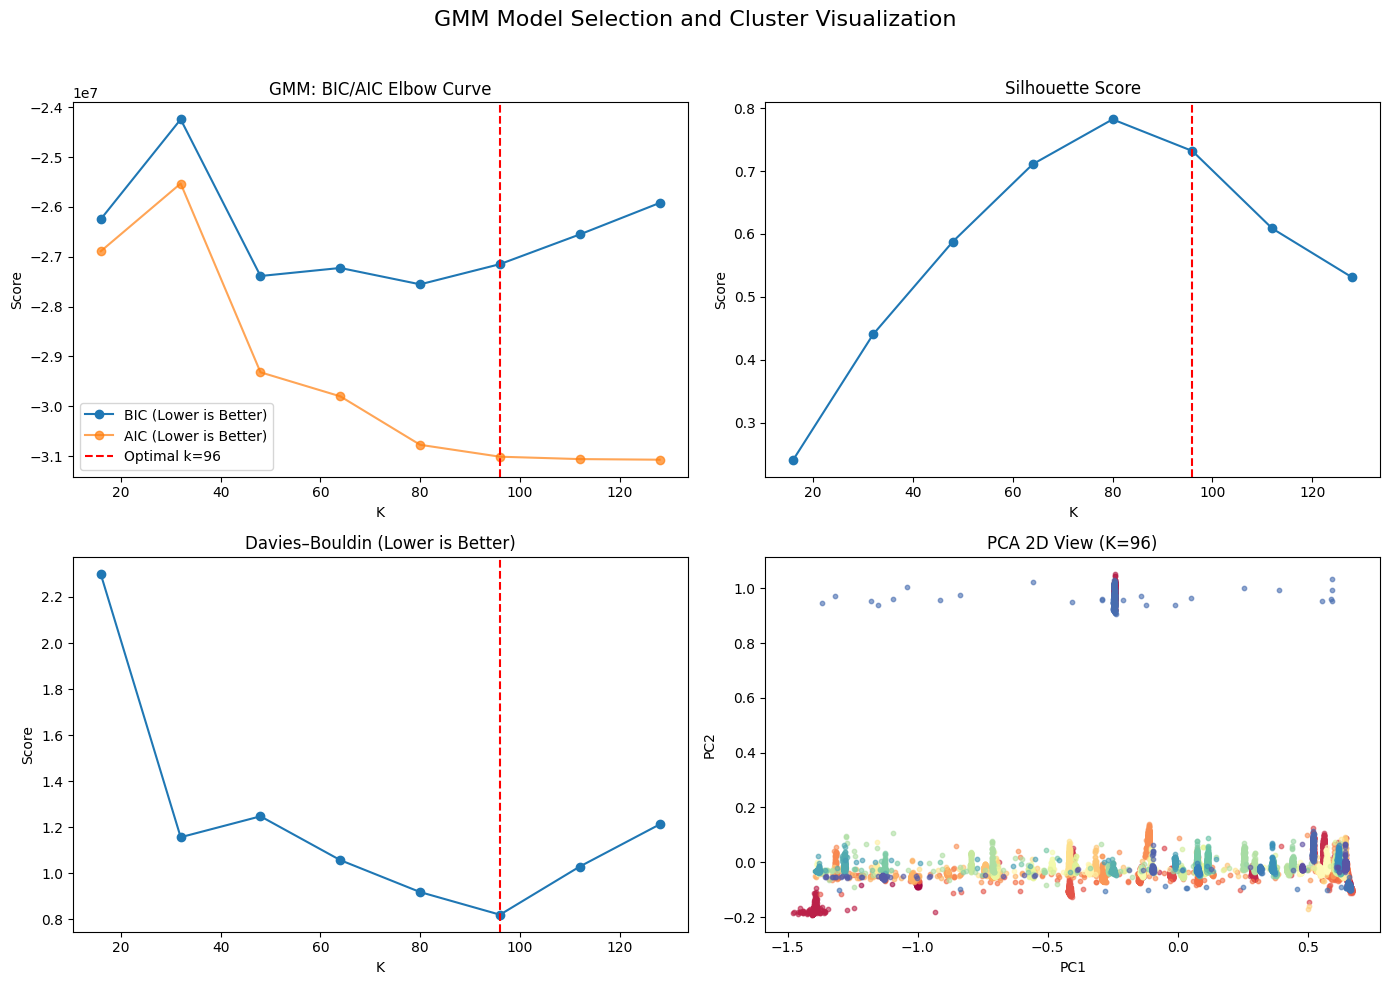

2025-11-01 19:01:52,813 | INFO | Pipeline complete. Artifacts saved.


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
GMM Full Pipeline v2: Merges new ingredient data with price, performs feature
engineering with only PRICE_PER_100G, conducts K-sweep (Elbow Curve),
automatically selects optimal K, builds the k-partite graph, and plots a NetworkX visualization.
"""

# -----------------------------
# Standard library imports
# -----------------------------
import json
import argparse
import math
import logging
from pathlib import Path
from collections import defaultdict

# -----------------------------
# Third-party imports
# -----------------------------
import numpy as np
import pandas as pd
from tqdm import tqdm
from rapidfuzz.fuzz import token_sort_ratio
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy import sparse
from scipy.stats import zscore
import networkx as nx
import joblib
import matplotlib.pyplot as plt

# -----------------------------
# Configuration (tweak as needed)
# -----------------------------
RANDOM_SEED = 42
data_dir = "../data"
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Feature config
TFIDF_NGRAM_RANGE = (1, 2)
TFIDF_MAX_FEATURES = 50000
PCA_COMPONENTS = 96
TOP_N_AISLES = 200
TEXT_SVD_COMPONENTS = 50 # SVD dimensions for text features

# Bucketing (P1) config
BUCKET_NAME_SIM_THRESHOLD = 0.92
BUCKET_PRICE_TOL_PCT = 0.10

# GMM sweep and final config
K_GRID = list(range(16, 129, 16)) # [16, 32, 48, 64, 80, 96, 112, 128]
COV_TYPES = ["full"] # Use full covariance for final model
GMM_N_INIT = 3
GMM_MAX_ITER = 300
TINY_COMPONENT_WEIGHT = 0.001

# Graph config
P3_LEVEL = "aisle_id"
P2P_SIM_PRUNE = 0.20
P2P_MAX_EDGES_PER_NODE = 15
P2P_FALLBACK_WEIGHT = 0.20

# -----------------------------
# Logging setup
# -----------------------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")

# -----------------------------
# Utility functions
# -----------------------------
def ensure_dir(path: Path):
    path.mkdir(parents=True, exist_ok=True)

def cos_sim(a, b):
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return float(a @ b / denom) if denom > 0 else 0.0

# -----------------------------
# Data Loading and Merging
# -----------------------------
def load_tables(data_dir: Path):
    """Load and selectively merge ONLY PRICE data onto the primary map file."""

    # NOTE: Assumes folder structure data_dir/raw and data_dir/processed
    primary_source_path = data_dir / "processed" / "product_data_with_ingredient_mapped.csv"
    price_source_path = data_dir / "raw" / "products_with_prices_ingredients_nutrition.csv"

    # --- Load Primary/Map Data ---
    if not primary_source_path.exists():
        raise FileNotFoundError(f"Primary map file not found: {primary_source_path}")

    products_map = pd.read_csv(primary_source_path)
    products_map.columns = [c.lower().replace(" ", "_").replace(",", "") for c in products_map.columns]

    if 'product_id' not in products_map.columns:
        products_map = products_map.rename(columns={products_map.columns[0]: 'product_id'})
    products_map['product_id'] = pd.to_numeric(products_map['product_id'], errors='coerce').astype('Int64')
    products_map = products_map.dropna(subset=['product_id'])

    # --- Load Price Data ---
    if not price_source_path.exists():
        raise FileNotFoundError(f"Price source file not found: {price_source_path}")

    products_price = pd.read_csv(price_source_path)
    products_price.columns = [c.lower().replace(" (usd)", "_usd").replace(" (g)", "_g").replace(" ", "_") for c in products_price.columns]

    # Identify ONLY price column to keep (price_usd)
    PRICE_COLS = ['product_id', 'price_usd']
    products_price_subset = products_price[PRICE_COLS]

    # --- Perform Selective Merge ---
    products = products_map.merge(products_price_subset, on='product_id', how='left')

    # Load lookup tables (assuming they are in the data_dir/raw)
    aisles = pd.read_csv(data_dir / "raw" / "aisles.csv")
    departments = pd.read_csv(data_dir / "raw" / "departments.csv")

    logging.info("Data loaded and selectively merged (Price only).")

    return {"products": products, "aisles": aisles, "departments": departments}

# -----------------------------
# Data Preprocessing and Feature Engineering
# -----------------------------
def normalize_products(df: pd.DataFrame) -> pd.DataFrame:
    """Derives price_per_100g, imputes, and cleans column names."""
    df = df.copy()

    expected_cols = {"product_id","product_name_x","aisle_id","department_id","price_usd","ingredients_text"}
    if not expected_cols.issubset(set(df.columns)):
         raise ValueError("Missing required columns after merge. Check product_data_with_ingredient_mapped.csv structure.")

    # --- Derive price_per_100g ---
    size_vals = []
    for name in df["product_name_x"].fillna(""):
        tokens = [t for t in name.replace("oz"," ").replace("ml"," ").replace("g"," ").split() if t.replace(".","",1).isdigit()]
        size_val = float(tokens[-1]) if tokens else np.nan
        size_vals.append(size_val)
    df["size_value_guess"] = size_vals

    df["price_per_100g"] = np.where(
        df["size_value_guess"].notna() & (df["size_value_guess"] > 0),
        df["price_usd"] / df["size_value_guess"] * 100.0,
        np.nan
    )

    # --- Clipping & Imputation (PRICE ONLY) ---
    PER_100G_COLS = ["price_per_100g"]
    df["price_per_100g"] = df["price_per_100g"].clip(lower=0.01, upper=100.0)

    for col in PER_100G_COLS:
        df[col] = df.groupby("aisle_id")[col].transform(lambda s: s.fillna(s.median()))
        df[col] = df[col].fillna(df[col].median())

    df = df.rename(columns={'product_name_x': 'product_name', 'ingredients_text': 'ingredients'})
    return df

def build_product_features(products: pd.DataFrame, aisles: pd.DataFrame):
    """Creates reduced feature matrix (Text SVD + Scaled Price + OHE Aisle)."""
    df = products.copy()
    PER_100G_COLS = ["price_per_100g"]

    # Meta columns for record keeping
    meta_cols = ["product_id", "product_name", "aisle_id", "department_id", "price_usd", "price_per_100g", "ingredients"]
    meta = df[meta_cols].copy()

    # 1. Text Features (TF-IDF + Truncated SVD)
    text_series = (df["product_name"].fillna("") + " " + df["ingredients"].fillna("")).astype(str)
    tfidf = TfidfVectorizer(ngram_range=TFIDF_NGRAM_RANGE, max_features=TFIDF_MAX_FEATURES, stop_words="english", sublinear_tf=True)
    X_text_sparse = tfidf.fit_transform(text_series)

    svd_text = TruncatedSVD(n_components=TEXT_SVD_COMPONENTS, random_state=RANDOM_SEED)
    X_text_reduced = svd_text.fit_transform(X_text_sparse)

    # 2. Numeric Block (PRICE ONLY, Robust Scaled)
    numeric = df[PER_100G_COLS].astype(float)
    scaler = RobustScaler()
    X_num = scaler.fit_transform(numeric)

    # 3. One-hot top aisles
    top_aisle_ids = df["aisle_id"].value_counts().nlargest(TOP_N_AISLES).index.tolist()
    aisle_mapped = df["aisle_id"].where(df["aisle_id"].isin(top_aisle_ids), other=-1)
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    X_aisle = ohe.fit_transform(aisle_mapped.values.reshape(-1,1))

    # 4. Concatenate and reduce dimensionality again (combining text, price, aisle)
    X_num_sparse = sparse.csr_matrix(X_num)
    X_combined_sparse = sparse.hstack([sparse.csr_matrix(X_text_reduced), X_num_sparse, X_aisle], format="csr")

    # Final SVD reduction to PCA_COMPONENTS (96)
    svd_final = TruncatedSVD(n_components=PCA_COMPONENTS, random_state=RANDOM_SEED)
    X_product_pca = svd_final.fit_transform(X_combined_sparse)

    # Persist transformers for reproducibility
    feat_dir = ARTIFACTS_DIR / "features"; ensure_dir(feat_dir)
    joblib.dump(svd_final, feat_dir / "svd_final.joblib")
    meta.to_parquet(feat_dir / "meta_product.parquet", index=False, engine="fastparquet")
    np.save(feat_dir / "X_product_pca.npy", X_product_pca)

    return X_product_pca, meta

# -----------------------------
# Bucketing and Aggregation (Standard V1 Logic)
# -----------------------------
def make_buckets(meta: pd.DataFrame) -> pd.DataFrame:
    """Cluster near-duplicates into BucketID."""
    def parse_brand(name: str) -> str:
        toks = name.split()
        return toks[0].lower() if toks else ""
    def parse_type(name: str) -> str:
        toks = name.split()
        return " ".join(t.lower() for t in toks[1:3]) if len(toks) > 1 else ""

    meta = meta.copy()
    meta["brand"] = meta["product_name"].fillna("").map(parse_brand)
    meta["type"] = meta["product_name"].fillna("").map(parse_type)

    bucket_ids = {}; next_bucket = 1

    for (_, _, aisle_id), block in tqdm(meta.groupby(["brand","type","aisle_id"], dropna=False), desc="Bucketing blocks"):
        idxs = list(block.index)
        parent = {i: i for i in idxs}

        def find(i):
            while parent[i] != i: parent[i] = parent[parent[i]]; i = parent[i]
            return i

        def union(i, j):
            ri, rj = find(i), find(j)
            if ri != rj: parent[rj] = ri

        for a in range(len(idxs)):
            for b in range(a+1, len(idxs)):
                i, j = idxs[a], idxs[b]
                name_i = block.loc[i, "product_name"] or ""; name_j = block.loc[j, "product_name"] or ""
                sim = token_sort_ratio(name_i, name_j) / 100.0

                pi = block.loc[i, "price_per_100g"]; pj = block.loc[j, "price_per_100g"]
                if pd.isna(pi) or pd.isna(pj) or max(pi, pj, 1e-6) == 0: price_ok = False
                else: price_ok = (abs(pi - pj) / max(pi, pj, 1e-6)) <= BUCKET_PRICE_TOL_PCT

                if sim >= BUCKET_NAME_SIM_THRESHOLD and price_ok: union(i, j)

        root_to_bucket = {}
        for i in idxs:
            r = find(i)
            if r not in root_to_bucket:
                root_to_bucket[r] = next_bucket
                next_bucket += 1
            bucket_ids[block.loc[i, "product_id"]] = root_to_bucket[r]

    bmap = pd.DataFrame({"product_id": list(bucket_ids.keys()), "bucket_id": list(bucket_ids.values())})
    bdir = ARTIFACTS_DIR / "buckets"; ensure_dir(bdir)
    bmap.to_parquet(bdir / "product_to_bucket.parquet", index=False, engine="fastparquet")

    stats = meta.merge(bmap, on="product_id", how="left") \
                .groupby("bucket_id").agg(size=("product_id","count"), mean_price_per_100g=("price_per_100g","mean")).reset_index()
    stats.to_parquet(bdir / "bucket_stats.parquet", index=False, engine="fastparquet")
    return bmap

def average_by_bucket(X_prod_pca: np.ndarray, meta: pd.DataFrame, bmap: pd.DataFrame):
    """Average reduced product features within each bucket → bucket vectors."""
    meta_b = meta.merge(bmap, on="product_id", how="left")
    buckets = meta_b["bucket_id"].values
    uniq_buckets, inv = np.unique(buckets, return_inverse=True)
    sums = np.zeros((len(uniq_buckets), X_prod_pca.shape[1]), dtype=np.float32)
    counts = np.zeros(len(uniq_buckets), dtype=np.int64)

    for i, bi in enumerate(inv):
        sums[bi] += X_prod_pca[i]
        counts[bi] += 1

    X_bucket = (sums.T / np.clip(counts, 1, None)).T
    bucket_index = pd.DataFrame({"bucket_id": uniq_buckets})

    fdir = ARTIFACTS_DIR / "features"; ensure_dir(fdir)
    np.save(fdir / "X_bucket_pca.npy", X_bucket)
    bucket_index.to_parquet(fdir / "bucket_index.parquet", index=False, engine="fastparquet")

    return X_bucket, bucket_index

# -----------------------------
# GMM Sweep and Selection (MODIFIED for evaluation)
# -----------------------------
def sweep_gmm_metrics(X_bucket: np.ndarray):
    """Fits GMM for all K in the grid and collects BIC/AIC/Silhouette metrics."""
    all_results = []
    logging.info(f"Starting K-sweep for K in {K_GRID} with {COV_TYPES[0]} covariance.")

    for k in K_GRID:
        # Initialize metric variables to prevent KeyError if calculation fails
        sil, db, ch, gmm = np.nan, np.nan, np.nan, None

        try:
            gmm = GaussianMixture(
                n_components=k, covariance_type=COV_TYPES[0], n_init=GMM_N_INIT,
                max_iter=GMM_MAX_ITER, random_state=RANDOM_SEED
            ).fit(X_bucket)

            bic = gmm.bic(X_bucket)
            aic = gmm.aic(X_bucket)
            tiny_frac = (gmm.weights_ < TINY_COMPONENT_WEIGHT).mean()
            labels = gmm.predict(X_bucket)

            # Compute external metrics only if the fit is stable (k>1 and tiny_frac is low)
            if k > 1 and tiny_frac <= 0.20:
                sil = silhouette_score(X_bucket, labels)
                db  = davies_bouldin_score(X_bucket, labels)
                ch  = calinski_harabasz_score(X_bucket, labels)

            logging.info(f"GMM sweep k={k} BIC={bic:.1f} tinyFrac={tiny_frac:.3f} sil={sil:.3f}")

            # --- Append result to list ---
            all_results.append({
                "k": k, "bic": bic, "aic": aic, "silhouette": sil,
                "davies_bouldin": db, # Safely defined
                "calinski_harabasz": ch, "tiny_frac": tiny_frac, "model": gmm
            })

        except Exception as e:
            # If GMM fitting or prediction fails, log the error and skip
            logging.error(f"Failed to fit GMM for k={k}: {e}")
            # Append a partial result so the subsequent DataFrame is not broken
            all_results.append({
                "k": k, "bic": np.nan, "aic": np.nan, "silhouette": np.nan,
                "davies_bouldin": np.nan, "calinski_harabasz": np.nan,
                "tiny_frac": np.nan, "model": None
            })
            continue

    return pd.DataFrame(all_results)

def suggest_optimal_k(results_df: pd.DataFrame):
    """Calculates a meta-score to suggest the optimal K."""
    df_f = results_df[results_df["model"].notna()].copy()

    # Ensure stable fit before suggesting
    df_f = df_f[df_f["tiny_frac"] <= 0.10].reset_index(drop=True)
    if df_f.empty:
         raise RuntimeError("No models passed the tiny component sanity check. Cannot suggest optimal K.")

    # Fill NaNs with median for stable z-scoring
    for col in ["silhouette", "davies_bouldin", "calinski_harabasz"]:
        if df_f[col].isna().any():
            df_f[col].fillna(df_f[col].median(), inplace=True)

    # z-score and flip where lower is better (BIC, AIC, DB)
    z = pd.DataFrame({
        "k": df_f["k"],
        "z_neg_bic":  zscore(-df_f["bic"]),
        "z_neg_aic":  zscore(-df_f["aic"]),
        "z_sil":      zscore(df_f["silhouette"]),
        "z_neg_db":   zscore(-df_f["davies_bouldin"]),
        "z_ch":       zscore(df_f["calinski_harabasz"])
    })

    # Meta score is the sum of all normalized metrics
    z["meta"] = z[["z_neg_bic", "z_neg_aic", "z_sil", "z_neg_db", "z_ch"]].sum(axis=1)

    k_best = int(z.loc[z["meta"].idxmax(), "k"])
    return k_best, df_f.set_index("k")

def plot_elbow_and_metrics(results_df: pd.DataFrame, k_best: int):
    """Plots BIC/AIC elbow curve and other metrics."""
    df = results_df[results_df["model"].notna()].sort_values("k").set_index("k")

    plt.figure(figsize=(14, 10))

    # BIC / AIC (lower is better)
    plt.subplot(2, 2, 1)
    plt.plot(df.index, df["bic"], marker='o', label="BIC (Lower is Better)")
    plt.plot(df.index, df["aic"], marker='o', label="AIC (Lower is Better)", alpha=0.7)
    plt.axvline(k_best, linestyle='--', color='red', label=f'Optimal k={k_best}')
    plt.title("GMM: BIC/AIC Elbow Curve"); plt.xlabel("K"); plt.ylabel("Score"); plt.legend()

    # Silhouette (higher better)
    plt.subplot(2, 2, 2)
    plt.plot(df.index, df["silhouette"], marker='o'); plt.axvline(k_best, linestyle='--', color='red')
    plt.title("Silhouette Score"); plt.xlabel("K"); plt.ylabel("Score")

    # Davies–Bouldin (lower better)
    plt.subplot(2, 2, 3)
    plt.plot(df.index, df["davies_bouldin"], marker='o'); plt.axvline(k_best, linestyle='--', color='red')
    plt.title("Davies–Bouldin (Lower is Better)"); plt.xlabel("K"); plt.ylabel("Score")

    # Visualization of Final Clusters (2D PCA)
    plt.subplot(2, 2, 4)

    # Load feature data for visualization
    X_bucket = np.load(ARTIFACTS_DIR / "features" / "X_bucket_pca.npy")

    # Fit the best model to get labels
    best_model = results_df[results_df['k'] == k_best]['model'].iloc[0]
    labels = best_model.predict(X_bucket)

    # Simple 2D PCA for visualization purposes
    from sklearn.decomposition import PCA
    X2 = PCA(n_components=2, random_state=RANDOM_SEED).fit_transform(X_bucket)

    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('Spectral', len(unique_labels))

    for i, c in enumerate(unique_labels):
        idx = labels == c
        plt.scatter(X2[idx,0], X2[idx,1], s=10, color=colors(i/len(unique_labels)), alpha=0.6)

    plt.title(f"PCA 2D View (K={k_best})")
    plt.xlabel("PC1"); plt.ylabel("PC2")

    plt.suptitle("GMM Model Selection and Cluster Visualization", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    reports_dir = ARTIFACTS_DIR / "reports"; ensure_dir(reports_dir)
    plt.savefig(reports_dir / "gmm_evaluation_plot.png")
    logging.info("Evaluation plot saved to artifacts/reports/gmm_evaluation_plot.png")
    plt.show()

# -----------------------------
# Graph Construction (Standard V1 Logic)
# -----------------------------
def build_kpartite_graph(bucket_index: pd.DataFrame, bucket_labels: np.ndarray,
                         X_bucket: np.ndarray, meta: pd.DataFrame,
                         bmap: pd.DataFrame, p3_level: str = P3_LEVEL, gmm: GaussianMixture = None):
    """Create nodes & edges for P1 (buckets), P2 (clusters), P3 (aisle/department) and similarity-based P2→P2 edges."""

    bi = bucket_index.copy()
    bi["cluster_id"] = bucket_labels

    # Recreate meta_b which holds product details, bucket IDs, and cluster IDs
    meta_b = meta.merge(bmap, on="product_id", how="left")
    meta_b = meta_b.merge(bi, on="bucket_id", how="left")

    # Build P1 nodes (bucket stats)
    bucket_stats = meta_b.groupby("bucket_id").agg(
        members=("product_id","count"),
        mean_price_per_100g=("price_per_100g","mean"),
    ).reset_index()
    # Add P3 assignment for P1 nodes
    bucket_stats = bucket_stats.merge(meta_b[['bucket_id', 'aisle_id', 'department_id']].drop_duplicates(), on='bucket_id', how='left')


    # Build P2 nodes (clusters) with centroid vectors
    df_p2 = bi.groupby("cluster_id").agg(n_buckets=("bucket_id","count")).reset_index()

    # Compute cluster centroids
    centroids = []
    for cid in df_p2["cluster_id"].tolist():
        rows = bi.index[bi["cluster_id"] == cid].tolist()
        centroids.append(X_bucket[rows].mean(axis=0))
    C = np.vstack(centroids)

    # Build P3 nodes (aisle or department)
    if p3_level not in {"aisle_id","department_id"}:
        raise ValueError("p3_level must be 'aisle_id' or 'department_id'")
    p3_nodes = bucket_stats[p3_level].dropna().unique().tolist()

    # Edges P1→P2
    edges_p1_p2 = bi[["bucket_id","cluster_id"]].copy(); edges_p1_p2["weight"] = 1.0

    # Edges P2→P3: cluster to its P3 node
    # Use meta_b (product data + cluster ID) to find majority P3 assignment
    cluster_to_p3 = {}
    for cid, sub in meta_b[["cluster_id", p3_level]].dropna().groupby("cluster_id"):
        p3_value = sub[p3_level].mode(dropna=True)
        assigned_p3 = int(p3_value.iloc[0]) if not p3_value.empty else int(sub[p3_level].iloc[0])
        cluster_to_p3[cid] = assigned_p3

    edges_p2_p3 = pd.DataFrame({
        "cluster_id": list(cluster_to_p3.keys()),
        p3_level: list(cluster_to_p3.values()),
        "weight": P2P_FALLBACK_WEIGHT
    })

    # Edges P2→P2: similarity among cluster centroids within same P3
    cluster_ids = df_p2["cluster_id"].tolist(); cid_to_row = {cid: i for i, cid in enumerate(cluster_ids)}
    p3_to_clusters = defaultdict(list)
    for cid, p3_val in cluster_to_p3.items(): p3_to_clusters[p3_val].append(cid)

    p2p_rows = []
    for p3_val, cids in p3_to_clusters.items():
        for i in range(len(cids)):
            u = cids[i]; u_vec = C[cid_to_row[u]]; sims = []
            for j in range(len(cids)):
                if i == j: continue
                v = cids[j]; v_vec = C[cid_to_row[v]]; s = cos_sim(u_vec, v_vec)
                if s >= P2P_SIM_PRUNE: sims.append((u, v, s))
            sims.sort(key=lambda t: t[2], reverse=True); sims = sims[:P2P_MAX_EDGES_PER_NODE]; p2p_rows.extend(sims)

    # Symmetrize
    pair_weights = defaultdict(list)
    for u, v, w in p2p_rows: pair_weights[tuple(sorted((u, v)))].append(w)

    edges_u, edges_v, edges_w = [], [], []
    for (u, v), ws in pair_weights.items():
        w = float(np.mean(ws))
        edges_u.extend([u, v]); edges_v.extend([v, u]); edges_w.extend([w, w])
    edges_p2_p2 = pd.DataFrame({"cluster_u": edges_u, "cluster_v": edges_v, "weight": edges_w}); edges_p2_p2["source"] = "centroid"

    # Persist nodes/edges to disk
    gdir = ARTIFACTS_DIR / "graph"; ensure_dir(gdir)
    bucket_stats.to_csv(gdir / "nodes_p1_buckets.csv", index=False)
    df_p2.to_csv(gdir / "nodes_p2_clusters.csv", index=False)
    pd.DataFrame({p3_level: p3_nodes}).to_csv(gdir / "nodes_p3_fallback.csv", index=False)
    edges_p1_p2.to_csv(gdir / "edges_p1_p2.csv", index=False)
    edges_p2_p2.to_csv(gdir / "edges_p2_p2_similarity.csv", index=False)
    edges_p2_p3.to_csv(gdir / "edges_p2_p3.csv", index=False)

    return bucket_stats, df_p2, edges_p1_p2, edges_p2_p2, edges_p2_p3

# -----------------------------
# Main CLI
# -----------------------------
def main():
    # parser = argparse.ArgumentParser(description="GMM clustering and k-partite graph pipeline.")
    # parser.add_argument("--data-dir", type=str, default=".", help="Root folder containing the raw/ and processed/ directories.")
    # parser.add_argument("--skip-training", action="store_true", help="Skip GMM sweep and load model/features if artifacts exist.")
    # args = parser.parse_args()

    np.random.seed(RANDOM_SEED)
    ensure_dir(ARTIFACTS_DIR)
    ensure_dir(ARTIFACTS_DIR / "features")
    ensure_dir(ARTIFACTS_DIR / "buckets")
    # This line ensures the 'gmm' folder exists for sweep_results.parquet
    ensure_dir(ARTIFACTS_DIR / "gmm") 
    ensure_dir(ARTIFACTS_DIR / "graph")
    # This line ensures the 'reports' folder exists for the final plot
    ensure_dir(ARTIFACTS_DIR / "reports")

    X_bucket, bucket_index, meta, bmap = None, None, None, None
    gmm_sweep_results = None

    # Check if we can skip training
    features_exist = (ARTIFACTS_DIR / "features" / "X_bucket_pca.npy").exists()
    model_exists = (ARTIFACTS_DIR / "gmm" / "model.joblib").exists()
    sweep_results_exist = (ARTIFACTS_DIR / "gmm" / "sweep_results.parquet").exists()

    if features_exist and model_exists and sweep_results_exist:
        logging.info("Skipping training and loading existing artifacts.")

        # Load necessary data for graph building/plotting
        X_bucket = np.load(ARTIFACTS_DIR / "features" / "X_bucket_pca.npy")
        bucket_index = pd.read_parquet(ARTIFACTS_DIR / "features" / "bucket_index.parquet")
        meta = pd.read_parquet(ARTIFACTS_DIR / "features" / "meta_product.parquet")
        bmap = pd.read_parquet(ARTIFACTS_DIR / "buckets" / "product_to_bucket.parquet")
        gmm_sweep_results = pd.read_parquet(ARTIFACTS_DIR / "gmm" / "sweep_results.parquet")

    else:
        # --- STEP 1: Data Preparation ---
        tables = load_tables(Path(data_dir))
        products = tables["products"]; aisles = tables["aisles"]; departments = tables["departments"]

        if products.empty or products['product_id'].isnull().all():
            logging.error("Merged product DataFrame is empty or invalid. Cannot proceed.")
            return

        products = normalize_products(products)
        X_product_pca, meta = build_product_features(products, aisles)
        bmap = make_buckets(meta)
        X_bucket, bucket_index = average_by_bucket(X_product_pca, meta, bmap)

        # --- STEP 2: GMM Sweep and Selection ---
        logging.info(f"Sweeping GMM metrics for Elbow plot (K={K_GRID})...")
        gmm_sweep_results = sweep_gmm_metrics(X_bucket)
        gmm_results_to_save = gmm_sweep_results.drop(columns=['model'], errors='ignore')
        gmm_results_to_save.to_parquet(ARTIFACTS_DIR / "gmm" / "sweep_results.parquet", index=False, engine="fastparquet")
        #gmm_sweep_results.to_parquet(ARTIFACTS_DIR / "gmm" / "sweep_results.parquet", index=False)


    # --- STEP 3: Final Model Training/Loading ---
    try:
        k_best, df_metrics = suggest_optimal_k(gmm_sweep_results)
        logging.info(f"Heuristic suggests optimal K: {k_best}. Proceeding with final model.")
    except RuntimeError as e:
        logging.error(f"Failed to suggest optimal K: {e}")
        return

    # Filter for the best stable model
    best_result = gmm_sweep_results[(gmm_sweep_results['k'] == k_best) & (gmm_sweep_results['tiny_frac'] <= 0.10)]

    if best_result.empty:
        logging.error(f"Optimal K={k_best} failed stability check. Using closest stable K or skipping graph build.")
        return

    gmm = best_result['model'].iloc[0]

    # --- Final Artifact Saving ---
    labels = gmm.predict(X_bucket)
    gdir = ARTIFACTS_DIR / "gmm"; ensure_dir(gdir)
    joblib.dump(gmm, gdir / "model.joblib")
    pd.DataFrame({"cluster_id": labels}).to_parquet(gdir / "bucket_labels.parquet", index=False, engine="fastparquet")

    # --- STEP 4: Graph Building ---
    logging.info("Building k-partite graph…")
    bucket_stats, df_p2, edges_p1_p2, edges_p2_p2, edges_p2_p3 = build_kpartite_graph(
        bucket_index=bucket_index, bucket_labels=labels, X_bucket=X_bucket, meta=meta, bmap=bmap, p3_level=P3_LEVEL, gmm=gmm
    )

    # --- STEP 5: Visualization and Report ---
    logging.info("Generating evaluation plot and saving artifacts.")
    plot_elbow_and_metrics(gmm_sweep_results, k_best)

    logging.info("Pipeline complete. Artifacts saved.")


if __name__ == "__main__":
    main()

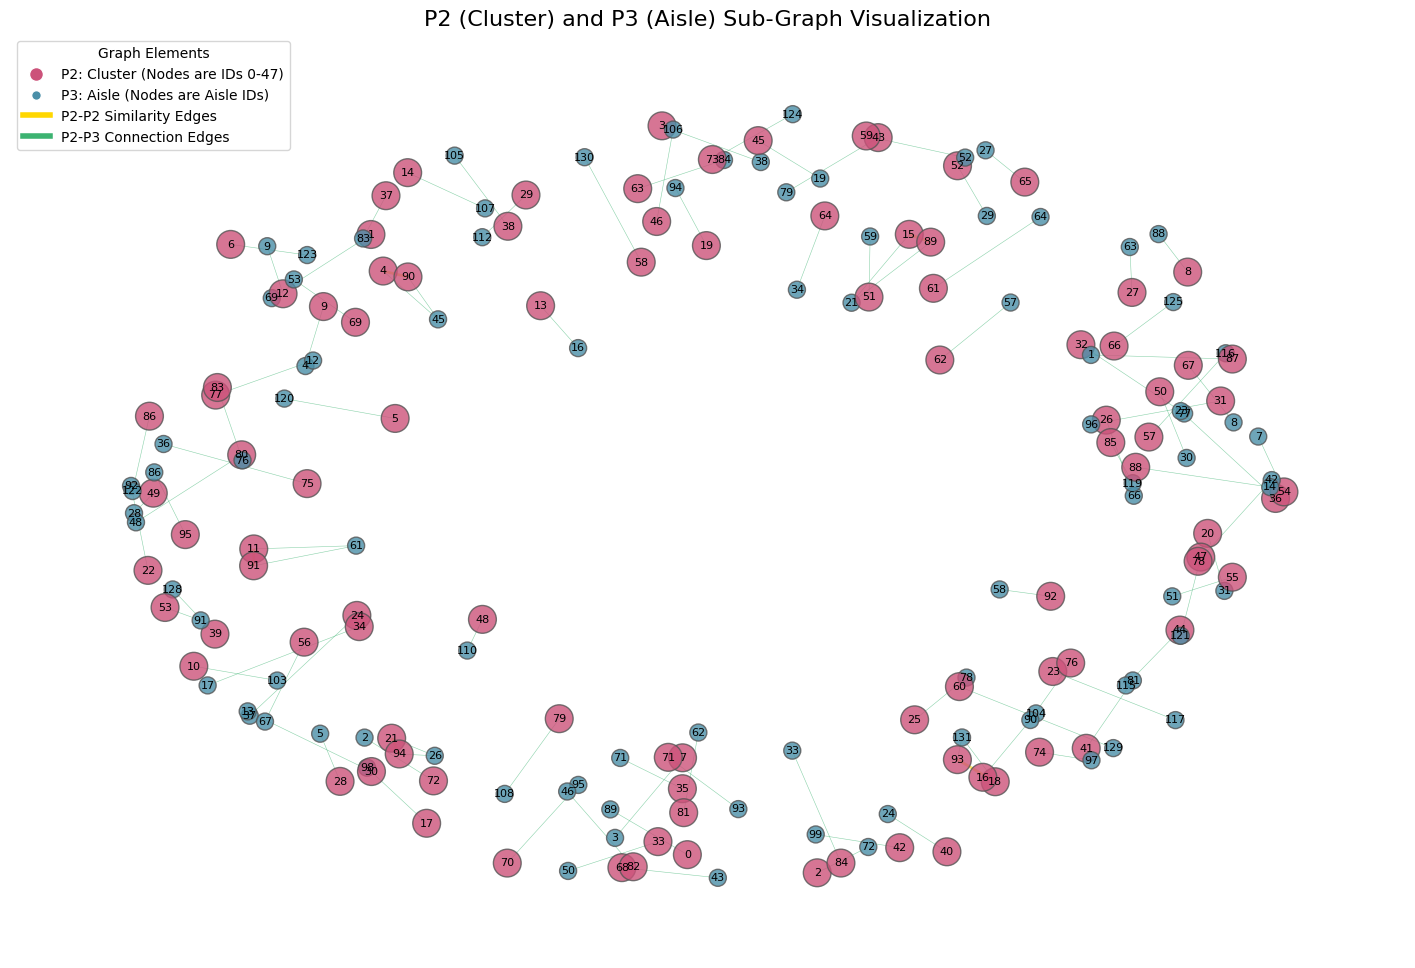

NetworkX graph successfully generated and visualized with distinct edge colors.
Total Nodes: 187
Total Edges: 101


In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --- 1. Define File Paths ---
P2_P2_EDGES_FILE = 'artifacts/graph/edges_p2_p2_similarity.csv'
P2_P3_EDGES_FILE = 'artifacts/graph/edges_p2_p3.csv'

# --- 2. Load Edge Data ---
try:
    # Assuming these files are in the same directory as the notebook
    df_p2p2 = pd.read_csv(P2_P2_EDGES_FILE)
    df_p2p3 = pd.read_csv(P2_P3_EDGES_FILE)
except FileNotFoundError as e:
    print(f"Error: Required file not found. Ensure '{e.filename}' is in the same directory as this notebook.")
    exit()

# --- 3. Create NetworkX Graph ---
G = nx.Graph()

# Add P2-P2 Edges (Cluster-to-Cluster Similarity)
# Ensure node names are strings for consistency (important for mixed node types)
df_p2p2['cluster_u'] = df_p2p2['cluster_u'].astype(str)
df_p2p2['cluster_v'] = df_p2p2['cluster_v'].astype(str)

p2p2_edges = [(row['cluster_u'], row['cluster_v'], {'weight': row['weight'], 'type': 'P2-P2_Similarity'}) 
              for index, row in df_p2p2.iterrows()]
G.add_edges_from(p2p2_edges)

# Add P2-P3 Edges (Cluster-to-Aisle)
# Prefix P3 nodes ('aisle_id') with 'A' to prevent ID collisions with P2 clusters.
df_p2p3['cluster_id'] = df_p2p3['cluster_id'].astype(str)
df_p2p3['aisle_id_str'] = 'A' + df_p2p3['aisle_id'].astype(str)

p2p3_edges = [(row['cluster_id'], row['aisle_id_str'], {'weight': row['weight'], 'type': 'P2-P3_Connection'}) 
              for index, row in df_p2p3.iterrows()]
G.add_edges_from(p2p3_edges)

# --- 4. Prepare Node Attributes ---
# Classify nodes into P2 (Clusters) and P3 (Aisles)
p2_nodes_list = [node for node in G.nodes() if not node.startswith('A')]
p3_nodes_list = [node for node in G.nodes() if node.startswith('A')]

# Assign color and size based on node type
node_colors = ['#CC527A' if node in p2_nodes_list else '#4A8FA8' for node in G.nodes()]
node_sizes = [400 if node in p2_nodes_list else 150 for node in G.nodes()]

# Create labels: map node ID to the display text
node_labels = {node: node.replace('A', '') for node in G.nodes()} # Remove the 'A' prefix for display

# --- 5. Prepare Edge Attributes for Visualization ---
# Define distinct colors for each edge type
p2p2_edge_color = '#FFD700'  # Gold for P2-P2 Similarity (e.g., strong connection between clusters)
p2p3_edge_color = '#3CB371'  # Medium Sea Green for P2-P3 Connection (e.g., clusters connecting to aisles)

edge_colors = []
for u, v, data in G.edges(data=True):
    if data['type'] == 'P2-P2_Similarity':
        edge_colors.append(p2p2_edge_color)
    elif data['type'] == 'P2-P3_Connection':
        edge_colors.append(p2p3_edge_color)
    else:
        edge_colors.append('#CCCCCC') # Default light gray for any other type

# Scale width by the 'weight' attribute, which is stored in the edge data
edge_widths = [data['weight'] * 2 for u, v, data in G.edges(data=True)]

# --- 6. Visualization ---

plt.figure(figsize=(18, 12))

# Calculate the layout (position of nodes)
# 'k' adjusts ideal distance between nodes. 'seed' makes the result repeatable.
pos = nx.spring_layout(G, k=0.15, iterations=50, seed=42) 

# Draw the nodes
nx.draw_networkx_nodes(G, pos, 
                       node_color=node_colors, 
                       node_size=node_sizes, 
                       alpha=0.8,
                       linewidths=1,
                       edgecolors='#555555')

# Draw the edges with new distinct colors
nx.draw_networkx_edges(G, pos, 
                       width=edge_widths, 
                       edge_color=edge_colors, # Use the list of colors we just created
                       alpha=0.6) # Increase alpha slightly for more vivid lines

# Draw the labels
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='black')

# --- 7. Final Touches ---
plt.title("P2 (Cluster) and P3 (Aisle) Sub-Graph Visualization", fontsize=16)

# Custom Legend for node and edge types
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='P2: Cluster (Nodes are IDs 0-47)',
           markerfacecolor='#CC527A', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='P3: Aisle (Nodes are Aisle IDs)',
           markerfacecolor='#4A8FA8', markersize=7),
    Line2D([0], [0], color=p2p2_edge_color, lw=4, label='P2-P2 Similarity Edges'),
    Line2D([0], [0], color=p2p3_edge_color, lw=4, label='P2-P3 Connection Edges')
]
plt.legend(handles=legend_elements, loc='upper left', title="Graph Elements", fontsize=10)

plt.axis('off') # Hide the axis ticks and frame
plt.show()

print("NetworkX graph successfully generated and visualized with distinct edge colors.")
print(f"Total Nodes: {G.number_of_nodes()}")
print(f"Total Edges: {G.number_of_edges()}")